# Binary Classification

So far, you've only created regression models. That is, you created models that produced floating-point predictions, such as, "houses in this neighborhood costs N thousand dollars." In this Colab, you'll create and evaluate a binary [classification model](https://developers.google.com/machine-learning/glossary/#classification_model).  That is, you'll create a model that answers a binary question. In this exercise, the binary question will be, "Are houses in this neighborhood above a certain price?"

https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/binary_classification.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=binary_classification_tf2-colab&hl=en



## Learning Objectives:

After doing this Colab, you'll know how to:

  * Convert a regression question into a classification question.
  * Modify the classification threshold and determine how that modification influences the model.
  * Experiment with different classification metrics to determine your model's effectiveness.

## The Dataset
  
Like several of the previous Colabs, this Colab uses the [California Housing Dataset](https://developers.google.com/machine-learning/crash-course/california-housing-data-description).

## Call the import statements

The following code imports the necessary modules.

In [1]:
#@title Load the imports

import numpy as np
import pandas as pd
import tensorflow as tf
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import math
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
# tf.keras.backend.set_floatx('float32')

print("Ran the import statements.")

Ran the import statements.


## Load the datasets from the internet

The following code cell loads the separate .csv files and creates the following two pandas DataFrames:

* `train_df`, which contains the training set
* `test_df`, which contains the test set

In [2]:
# Load the dataset
orign_train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

# Shuffle the examples
orign_train_df = orign_train_df.reindex(np.random.permutation(orign_train_df.index))

Unlike some of the previous Colabs, the preceding code cell did not scale the label (`median_house_value`).  The following section ("Normalize values") provides an alternative approach.

## Normalize values

When creating a model with multiple features, the values of each feature should cover roughly the same range.  For example, if one feature's range spans 500 to 100,000 and another feature's range spans 2 to 12, then the model will be difficult or impossible to train. Therefore, you should 
[normalize](https://developers.google.com/machine-learning/glossary/#normalization) features in a multi-feature model. 

The following code cell normalizes datasets by converting each raw value (including the label) to its Z-score. A **Z-score** is the number of standard deviations from the mean for a particular raw value. For example, consider a feature having the following characteristics:

  * The mean is 60.
  * The standard deviation is 10.

The raw value 75 would have a Z-score of +1.5:

```
  Z-score = (75 - 60) / 10 = +1.5
```

The raw value 38 would have a Z-score of -2.2:

```
  Z-score = (38 - 60) / 10 = -2.2
```

In [3]:
# Calculate the Z-scores of each column in the training set and
# write those Z-scores into a new pandas DataFrame named train_df_norm.
train_df_mean = orign_train_df.mean()
train_df_std = orign_train_df.std()
train_df_norm = (orign_train_df - train_df_mean)/train_df_std

# Examine some of the values of the normalized training set. Notice that most 
# Z-scores fall between -2 and +2.
train_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
2216,1.1,-0.8,0.5,-0.5,-0.6,-0.6,-0.6,0.1,-0.7
14707,-1.3,1.8,-0.4,-1.0,-1.0,-1.0,-1.1,-0.9,-1.3
7124,0.6,-0.8,0.6,-0.7,-0.7,-0.7,-0.7,0.1,-0.1
16326,-1.5,1.0,1.2,-0.3,-0.2,-0.2,-0.3,0.3,0.5
4367,0.8,-0.8,0.6,-0.5,-0.6,-0.6,-0.6,0.2,-0.2


In [4]:
# Calculate the Z-scores of each column in the test set and
# write those Z-scores into a new pandas DataFrame named test_df_norm.
test_df_mean = test_df.mean()
test_df_std  = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std

## Task 1: Create a binary label

In classification problems, the label for every example must be either 0 or 1. Unfortunately, the natural label in the California Housing Dataset, `median_house_value`, contains floating-point values like 80,100 or 85,700 rather than 0s and 1s, while the normalized version of `median_house_values` contains floating-point values primarily between -3 and +3.

Your task is to create a new column named `median_house_value_is_high` in both the training set and the test set . If the `median_house_value` is higher than a certain arbitrary value (defined by `threshold`), then set `median_house_value_is_high` to 1. Otherwise, set `median_house_value_is_high` to 0. 

**Hint:** The cells in the `median_house_value_is_high` column must each hold `1` and `0`, not `True` and `False`. To convert `True` and `False` to  `1` and `0`, call the pandas DataFrame function `astype(float)`. 

In [5]:
#@title Double-click for possible solutions.

# We arbitrarily set the threshold to 265,000, which is 
# the 75th percentile for median house values.  Every neighborhood
# with a median house price above 265,000 will be labeled 1, 
# and all other neighborhoods will be labeled 0.
threshold = 265000
train_df_norm["median_house_value_is_high"] = (orign_train_df["median_house_value"] > threshold).astype(float)
test_df_norm["median_house_value_is_high"] = (test_df["median_house_value"] > threshold).astype(float) 
train_df_norm["median_house_value_is_high"].head(8000)


# Alternatively, instead of picking the threshold
# based on raw house values, you can work with Z-scores.
# For example, the following possible solution uses a Z-score
# of +1.0 as the threshold, meaning that no more
# than 16% of the values in median_house_value_is_high
# will be labeled 1.

# threshold_in_Z = 1.0 
# train_df_norm["median_house_value_is_high"] = (train_df_norm["median_house_value"] > threshold_in_Z).astype(float)
# test_df_norm["median_house_value_is_high"] = (test_df_norm["median_house_value"] > threshold_in_Z).astype(float) 


2216    0.0
14707   0.0
7124    0.0
16326   1.0
4367    0.0
         ..
7355    0.0
1089    0.0
10927   0.0
14953   0.0
3940    0.0
Name: median_house_value_is_high, Length: 8000, dtype: float64

In [6]:
train_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,median_house_value_is_high
2216,1.1,-0.8,0.5,-0.5,-0.6,-0.6,-0.6,0.1,-0.7,0.0
14707,-1.3,1.8,-0.4,-1.0,-1.0,-1.0,-1.1,-0.9,-1.3,0.0
7124,0.6,-0.8,0.6,-0.7,-0.7,-0.7,-0.7,0.1,-0.1,0.0
16326,-1.5,1.0,1.2,-0.3,-0.2,-0.2,-0.3,0.3,0.5,1.0
4367,0.8,-0.8,0.6,-0.5,-0.6,-0.6,-0.6,0.2,-0.2,0.0


In [7]:
test_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,median_house_value_is_high
0,-1.2,0.8,-0.1,0.6,0.3,0.1,0.3,1.5,1.2,1.0
1,0.6,-0.6,1.1,-0.5,-0.5,-0.6,-0.6,-0.1,-0.3,0.0
2,0.9,-0.9,-0.1,0.5,-0.1,0.1,0.0,1.1,0.6,1.0
3,0.6,-0.9,-0.1,-1.2,-1.2,-1.3,-1.3,1.3,1.1,1.0
4,-0.0,0.3,-0.8,-0.6,-0.7,-0.5,-0.7,-0.5,-1.1,0.0


## Represent features in feature columns

This code cell specifies the features that you'll ultimately train the model on and how each of those features will be represented. The transformations (collected in `feature_layer`) don't actually get applied until you pass a DataFrame to it, which will happen when we train the model. 

In [8]:
# Create an empty list that will eventually hold all feature columns.
feature_columns = [f for f in list(train_df_norm.columns) if f not in [ "median_house_value", "median_house_value_is_high"]]

print(feature_columns)

# X_train = orign_train_df[feature_columns] 
# Y_train = orign_train_df[["median_house_value"]]

# X_train.head()

DenseFeatures = ["median_income", "total_rooms"]
# feature_columns = DenseFeatures

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']


## Define functions that build and train a model

The following code cell defines two functions:

  * `create_model(my_learning_rate, feature_layer, my_metrics)`, which defines the model's
    topography.
  * `train_model(model, dataset, epochs, label_name, batch_size, shuffle)`, uses input features and labels to train the model.

Prior exercises used [ReLU](https://developers.google.com/machine-learning/glossary#ReLU) as the [activation function](https://developers.google.com/machine-learning/glossary#activation_function). By contrast, this exercise uses [sigmoid](https://developers.google.com/machine-learning/glossary#sigmoid_function) as the activation function. 

In [9]:
train_df, valid_df = train_test_split(train_df_norm, test_size=0.2)

from sklearn.model_selection import train_test_split

tfm = transforms.Compose([
    transforms.ToTensor(), # range [0, 255] -> [0.0,1.0]
])

class MyDataset(Dataset):
 
    def __init__(self, df, tfm):
       
        self.transform = tfm
        x=df[feature_columns].values
        y=df[["median_house_value_is_high"]].values

        self.x_train=torch.tensor(x,dtype=torch.float32)
        self.y_train=torch.tensor(y,dtype=torch.float32)    
           

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self,idx):
        return self.x_train[idx],self.y_train[idx]

train_ds = MyDataset(train_df, tfm)
valid_ds = MyDataset(valid_df, tfm)
test_ds = MyDataset(test_df_norm, tfm)

In [10]:
learning_rate = 0.001
n_epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"
classification_threshold = 0.35

train_loader=DataLoader(train_ds,batch_size=batch_size,shuffle=True)

valid_loader=DataLoader(valid_ds,batch_size=batch_size,shuffle=True)

test_loader=DataLoader(test_ds,batch_size=batch_size,shuffle=False)

In [11]:
from torch import nn
import torch.nn.functional as F

class Sequential(nn.Module):
    def __init__(self):
        super(Sequential, self).__init__()
        self.hid = nn.Sequential(
                    nn.Linear(8, 1),
                )
        self.s = nn.Sigmoid()
        # self.m = nn.Softmax()
    def forward(self, x):
        out = self.hid(x)
        out = self.s(out)
        # out = self.m(out)
        return out
    
Sequential()    

Sequential(
  (hid): Sequential(
    (0): Linear(in_features=8, out_features=1, bias=True)
  )
  (s): Sigmoid()
)

In [12]:
model = Sequential()

optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.1, eps=1e-08, 
#                                 weight_decay=0.1, momentum=0.2, centered=False)
loss_func = nn.BCELoss()  
    
    
epoch_train_loss = []

epoch_train_acc = []

    
for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []    
    
    # for batch in tqdm(trainloader):
    for batch in tqdm(train_loader):
        X, y = batch          
        # print(X)
        y_hat = model(X)
        loss = loss_func(y_hat, y) #rmse
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
        
        pred = (y_hat > classification_threshold)
        acc = (pred == y).sum() / X.shape[0]   
        
        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    train_loss = sum(train_loss) / len(train_loss)
    train_accs = sum(train_accs) / len(train_accs)
    
    epoch_train_loss.append(train_loss)
    epoch_train_acc.append(train_accs)   
        
    # Print the information.
    print(f"[ Epoch | {epoch + 1:03d}/{n_epochs:03d} ] \
          train_loss = {train_loss:.5f} accuracy = {train_accs:.5f}")

print("Defined the build_model and train_model functions.")


[ Epoch | 001/020 ]           train_loss = 0.73305 accuracy = 0.25081



[ Epoch | 002/020 ]           train_loss = 0.64639 accuracy = 0.25397



[ Epoch | 003/020 ]           train_loss = 0.58702 accuracy = 0.30838



[ Epoch | 004/020 ]           train_loss = 0.53872 accuracy = 0.46191



[ Epoch | 005/020 ]           train_loss = 0.49860 accuracy = 0.60081



[ Epoch | 006/020 ]           train_loss = 0.46525 accuracy = 0.68684



[ Epoch | 007/020 ]           train_loss = 0.43773 accuracy = 0.74191



[ Epoch | 008/020 ]           train_loss = 0.41515 accuracy = 0.77529



[ Epoch | 009/020 ]           train_loss = 0.39692 accuracy = 0.79728



[ Epoch | 010/020 ]           train_loss = 0.38203 accuracy = 0.81390



[ Epoch | 011/020 ]           train_loss = 0.37010 accuracy = 0.82588



[ Epoch | 012/020 ]           train_loss = 0.36059 accuracy = 0.83169



[ Epoch | 013/020 ]           train_loss = 0.35329 accuracy = 0.83699



[ Epoch | 014/020 ]           train_loss = 0.34755 accuracy = 0.84022



[ Epoch | 015/020 ]           train_loss = 0.34298 accuracy = 0.84301



[ Epoch | 016/020 ]           train_loss = 0.33927 accuracy = 0.84471



[ Epoch | 017/020 ]           train_loss = 0.33628 accuracy = 0.84676



[ Epoch | 018/020 ]           train_loss = 0.33370 accuracy = 0.84735



[ Epoch | 019/020 ]           train_loss = 0.33142 accuracy = 0.84831



[ Epoch | 020/020 ]           train_loss = 0.32944 accuracy = 0.84926
Defined the build_model and train_model functions.


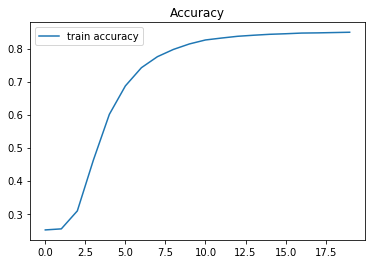

In [13]:
import matplotlib.pyplot as plt

# Loss curve
plt.plot(epoch_train_acc)
plt.title('Accuracy')
plt.legend(['train accuracy'])
plt.savefig('acc.png')
plt.show()

In [14]:
# These are used to record information in validation.
test_loss = []
test_accs = []

# Iterate the validation set by batches.
for batch in tqdm(test_loader):
    X, y = batch   
   
    y_hat = model(X)
    loss = loss_func(y_hat, y) #rmse
    
    pred = (y_hat > classification_threshold)
    acc = (pred == y).sum() / X.shape[0]  

    # Record the loss and accuracy.
    test_loss.append(loss.item())
    test_accs.append(acc)

 # The average loss and accuracy for entire validation set is the average of the recorded values.
test_loss = sum(test_loss) / len(test_loss)
test_accs = sum(test_accs) / len(test_accs) 

# Print the information.
print(f"test_loss = {test_loss:.5f} accuracy = {test_accs:.5f}")


test_loss = 0.33786 accuracy = 0.84733


## Task 3: Add precision and recall as metrics

Relying solely on accuracy, particularly for a class-imbalanced data set (like ours), can be a poor way to judge a classification model.  Modify the code in the following code cell to enable the model to measure not only accuracy but also precision and recall. We have
added accuracy and precision; your task is to add recall. See the [TensorFlow Reference](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall) for details.



In [15]:
learning_rate = 0.001
n_epochs = 20
batch_size = 100
classification_threshold = 0.35
label_name = "median_house_value_is_high"

In [16]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                      threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision' 
                                 ),
      tf.keras.metrics.Recall(thresholds=classification_threshold,
                              name="recall"),
]

In [17]:
def perf_measure(y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)): 
        if y_actual[i]==y_pred[i]==1:
            TP += 1
        if y_pred[i]==1 and y_actual[i]!=y_pred[i]:
            FP += 1
        if y_actual[i]==y_pred[i]==0:
            TN += 1
        if y_pred[i]==0 and y_actual[i]!=y_pred[i]:
            FN += 1
    return(TP, FP, TN, FN)

In [18]:
model = Sequential()

optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.1, eps=1e-08, 
#                                 weight_decay=0.1, momentum=0.2, centered=False)
loss_func = nn.BCELoss()  
    
    
epoch_train_loss = []

epoch_valid_loss = []

epoch_accuracy = []
epoch_precision = []
epoch_recall = []
    
for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []    
    
    # for batch in tqdm(trainloader):
    for batch in tqdm(train_loader):
        X, y = batch          
        # print(X)
        y_hat = model(X)
        loss = loss_func(y_hat, y) #rmse
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
        
        # Record the loss and accuracy.
        train_loss.append(loss.item())      
                       
    train_loss = sum(train_loss) / len(train_loss)
    
    epoch_train_loss.append(train_loss)
   
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()
    
    # These are used to record information in validation.
    valid_loss = []
    
    valid_accuracy = []
    valid_precision = []
    valid_recall = []
    
    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):
        X, y = batch   
       
        y_hat = model(X)
        loss = loss_func(y_hat, y) #rmse
        
        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        
        
        pred = (y_hat > classification_threshold).type(torch.LongTensor)
        acc = (pred == y).sum() / X.shape[0]  
        
        TP, FP, TN, FN = perf_measure(y, pred)        
          
        Precision = TP / (TP + FP)
        Recall = TP / (TP + FN)
        
        valid_accuracy.append(acc)
        valid_precision.append(Precision)
        valid_recall.append(Recall)
      
        
     # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    epoch_valid_loss.append(valid_loss)
    
    epoch_accuracy.append(sum(valid_accuracy) / len(valid_accuracy))
    epoch_precision.append(sum(valid_precision) / len(valid_precision))
    epoch_recall.append(sum(valid_recall) / len(valid_recall))
        
    # Print the information.
    print(f"[ Epoch | {epoch + 1:03d}/{n_epochs:03d} ] \
          train_loss = {train_loss:.5f} valid_loss = {valid_loss:.5f} \
          Precision = {Precision:.5f} Precision = {Precision:.5f} Recall = {Recall:.5f}")

print("Defined the build_model and train_model functions.")


[ Epoch | 001/020 ]           train_loss = 0.65521 valid_loss = 0.59956           Precision = 0.21591 Precision = 0.21591 Recall = 0.90476



[ Epoch | 002/020 ]           train_loss = 0.57128 valid_loss = 0.54235           Precision = 0.35593 Precision = 0.35593 Recall = 1.00000



[ Epoch | 003/020 ]           train_loss = 0.52156 valid_loss = 0.49941           Precision = 0.50000 Precision = 0.50000 Recall = 0.87500



[ Epoch | 004/020 ]           train_loss = 0.48280 valid_loss = 0.46525           Precision = 0.60870 Precision = 0.60870 Recall = 0.77778



[ Epoch | 005/020 ]           train_loss = 0.45179 valid_loss = 0.43779           Precision = 0.58333 Precision = 0.58333 Recall = 0.77778



[ Epoch | 006/020 ]           train_loss = 0.42664 valid_loss = 0.41529           Precision = 0.60870 Precision = 0.60870 Recall = 0.63636



[ Epoch | 007/020 ]           train_loss = 0.40622 valid_loss = 0.39739           Precision = 0.58065 Precision = 0.58065 Recall = 0.81818



[ Epoch | 008/020 ]           train_loss = 0.38991 valid_loss = 0.38284           Precision = 0.56522 Precision = 0.56522 Recall = 0.68421



[ Epoch | 009/020 ]           train_loss = 0.37668 valid_loss = 0.37100           Precision = 0.72000 Precision = 0.72000 Recall = 0.72000



[ Epoch | 010/020 ]           train_loss = 0.36579 valid_loss = 0.36141           Precision = 0.56000 Precision = 0.56000 Recall = 0.58333



[ Epoch | 011/020 ]           train_loss = 0.35701 valid_loss = 0.35358           Precision = 0.66667 Precision = 0.66667 Recall = 0.75000



[ Epoch | 012/020 ]           train_loss = 0.34970 valid_loss = 0.34719           Precision = 0.76923 Precision = 0.76923 Recall = 0.76923



[ Epoch | 013/020 ]           train_loss = 0.34383 valid_loss = 0.34195           Precision = 0.73077 Precision = 0.73077 Recall = 0.76000



[ Epoch | 014/020 ]           train_loss = 0.33897 valid_loss = 0.33763           Precision = 0.59091 Precision = 0.59091 Recall = 0.52000



[ Epoch | 015/020 ]           train_loss = 0.33502 valid_loss = 0.33423           Precision = 0.74194 Precision = 0.74194 Recall = 0.71875



[ Epoch | 016/020 ]           train_loss = 0.33189 valid_loss = 0.33150           Precision = 0.62857 Precision = 0.62857 Recall = 0.73333



[ Epoch | 017/020 ]           train_loss = 0.32926 valid_loss = 0.32925           Precision = 0.33333 Precision = 0.33333 Recall = 0.50000



[ Epoch | 018/020 ]           train_loss = 0.32704 valid_loss = 0.32741           Precision = 0.70000 Precision = 0.70000 Recall = 0.73684



[ Epoch | 019/020 ]           train_loss = 0.32518 valid_loss = 0.32582           Precision = 0.65000 Precision = 0.65000 Recall = 0.81250



[ Epoch | 020/020 ]           train_loss = 0.32352 valid_loss = 0.32439           Precision = 0.72000 Precision = 0.72000 Recall = 0.81818
Defined the build_model and train_model functions.


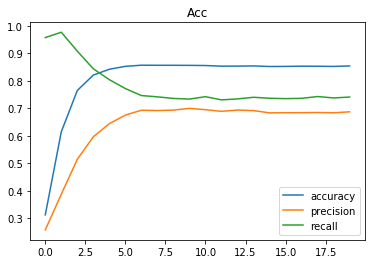

In [19]:
import matplotlib.pyplot as plt

# Loss curve
plt.plot(epoch_accuracy)
plt.plot(epoch_precision)
plt.plot(epoch_recall)
plt.title('Acc')
plt.legend(['accuracy', "precision", "recall"])
plt.savefig('acc.png')
plt.show()

## Task 4: Experiment with the classification threshold (if time permits)

Experiment with different values for `classification_threshold` in the code cell within "Invoke the creating, training, and plotting functions."  What value of `classification_threshold` produces the highest accuracy?

In [20]:
learning_rate = 0.001
n_epochs = 20
batch_size = 100
classification_threshold = 0.52
label_name = "median_house_value_is_high"

In [21]:
model = Sequential()

optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.1, eps=1e-08, 
#                                 weight_decay=0.1, momentum=0.2, centered=False)
loss_func = nn.BCELoss()  
    
    
epoch_train_loss = []

epoch_valid_loss = []

epoch_accuracy = []
epoch_precision = []
epoch_recall = []
    
for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []    
    
    # for batch in tqdm(trainloader):
    for batch in tqdm(train_loader):
        X, y = batch          
        # print(X)
        y_hat = model(X)
        loss = loss_func(y_hat, y) #rmse
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
        
        # Record the loss and accuracy.
        train_loss.append(loss.item())      
                       
    train_loss = sum(train_loss) / len(train_loss)
    
    epoch_train_loss.append(train_loss)
   
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()
    
    # These are used to record information in validation.
    valid_loss = []
    
    valid_accuracy = []
    valid_precision = []
    valid_recall = []
    
    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):
        X, y = batch   
       
        y_hat = model(X)
        loss = loss_func(y_hat, y) #rmse
        
        # Record the loss and accuracy.
        valid_loss.append(loss.item())       

        pred = (y_hat > classification_threshold).type(torch.LongTensor)
        acc = (pred == y).sum() / X.shape[0]  
        
        TP, FP, TN, FN = perf_measure(y, pred)        
          
        Precision = TP / (TP + FP)
        Recall = TP / (TP + FN)
      
        valid_accuracy.append(acc)
        valid_precision.append(Precision)
        valid_recall.append(Recall)
        
     # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    epoch_valid_loss.append(valid_loss)
    
    epoch_accuracy.append(sum(valid_accuracy) / len(valid_accuracy))
    epoch_precision.append(sum(valid_precision) / len(valid_precision))
    epoch_recall.append(sum(valid_recall) / len(valid_recall))
        
    # Print the information.
    print(f"[ Epoch | {epoch + 1:03d}/{n_epochs:03d} ] \
          train_loss = {train_loss:.5f} valid_loss = {valid_loss:.5f} \
          Precision = {Precision:.5f} Precision = {Precision:.5f} Recall = {Recall:.5f}")

print("Defined the build_model and train_model functions.")


[ Epoch | 001/020 ]           train_loss = 0.71660 valid_loss = 0.65615           Precision = 0.53333 Precision = 0.53333 Recall = 0.44444



[ Epoch | 002/020 ]           train_loss = 0.62122 valid_loss = 0.58945           Precision = 0.93333 Precision = 0.93333 Recall = 0.58333



[ Epoch | 003/020 ]           train_loss = 0.56409 valid_loss = 0.53933           Precision = 0.84615 Precision = 0.84615 Recall = 0.44000



[ Epoch | 004/020 ]           train_loss = 0.51905 valid_loss = 0.49897           Precision = 0.90909 Precision = 0.90909 Recall = 0.31250



[ Epoch | 005/020 ]           train_loss = 0.48246 valid_loss = 0.46571           Precision = 0.77778 Precision = 0.77778 Recall = 0.36842



[ Epoch | 006/020 ]           train_loss = 0.45240 valid_loss = 0.43862           Precision = 1.00000 Precision = 1.00000 Recall = 0.45833



[ Epoch | 007/020 ]           train_loss = 0.42758 valid_loss = 0.41618           Precision = 0.77778 Precision = 0.77778 Recall = 0.30435



[ Epoch | 008/020 ]           train_loss = 0.40747 valid_loss = 0.39818           Precision = 0.75000 Precision = 0.75000 Recall = 0.39130



[ Epoch | 009/020 ]           train_loss = 0.39110 valid_loss = 0.38369           Precision = 0.88235 Precision = 0.88235 Recall = 0.62500



[ Epoch | 010/020 ]           train_loss = 0.37798 valid_loss = 0.37197           Precision = 0.92857 Precision = 0.92857 Recall = 0.44828



[ Epoch | 011/020 ]           train_loss = 0.36738 valid_loss = 0.36294           Precision = 0.89474 Precision = 0.89474 Recall = 0.65385



[ Epoch | 012/020 ]           train_loss = 0.35916 valid_loss = 0.35565           Precision = 0.81250 Precision = 0.81250 Recall = 0.56522



[ Epoch | 013/020 ]           train_loss = 0.35257 valid_loss = 0.34997           Precision = 1.00000 Precision = 1.00000 Recall = 0.48148



[ Epoch | 014/020 ]           train_loss = 0.34733 valid_loss = 0.34547           Precision = 0.92308 Precision = 0.92308 Recall = 0.57143



[ Epoch | 015/020 ]           train_loss = 0.34302 valid_loss = 0.34171           Precision = 0.92308 Precision = 0.92308 Recall = 0.57143



[ Epoch | 016/020 ]           train_loss = 0.33943 valid_loss = 0.33864           Precision = 0.87500 Precision = 0.87500 Recall = 0.45161



[ Epoch | 017/020 ]           train_loss = 0.33650 valid_loss = 0.33613           Precision = 0.85714 Precision = 0.85714 Recall = 0.52174



[ Epoch | 018/020 ]           train_loss = 0.33402 valid_loss = 0.33403           Precision = 0.95238 Precision = 0.95238 Recall = 0.64516



[ Epoch | 019/020 ]           train_loss = 0.33184 valid_loss = 0.33213           Precision = 0.90000 Precision = 0.90000 Recall = 0.39130



[ Epoch | 020/020 ]           train_loss = 0.32987 valid_loss = 0.33043           Precision = 0.88235 Precision = 0.88235 Recall = 0.60000
Defined the build_model and train_model functions.


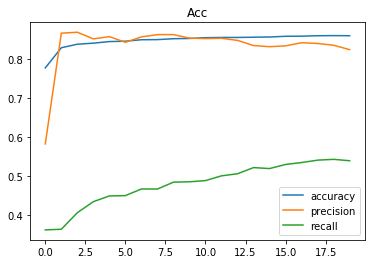

In [22]:
import matplotlib.pyplot as plt

# Loss curve
plt.plot(epoch_accuracy)
plt.plot(epoch_precision)
plt.plot(epoch_recall)
plt.title('Acc')
plt.legend(['accuracy', "precision", "recall"])
plt.savefig('acc.png')
plt.show()

## Task 5: Summarize model performance (if time permits)

If time permits, add one more metric that attempts to summarize the model's overall performance. 

In [23]:
learning_rate = 0.001
n_epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"

# AUC is a reasonable "summary" metric for 
# classification models.
# Here is the updated definition of METRICS to 
# measure AUC:
METRICS = [
      tf.keras.metrics.AUC(num_thresholds=100, name='auc'),
]

In [24]:
def calcu_AUC(label, pre):
    """
    适用于ｐｙｔｈｏｎ3.0以上版本
    """
    # 计算正样本和负样本的索引，以便索引出之后的概率值
    pos = [i for i in range(len(label)) if label[i] == 1]
    neg = [i for i in range(len(label)) if label[i] == 0]
 
    auc = 0
    for i in pos:
        for j in neg:
            if pre[i] > pre[j]:
                auc += 1
            elif pre[i] == pre[j]:
                auc += 0.5
 
    return auc / (len(pos)*len(neg))

In [25]:
model = Sequential()

optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.1, eps=1e-08, 
#                                 weight_decay=0.1, momentum=0.2, centered=False)
loss_func = nn.BCELoss()  
    
    
epoch_train_loss = []

epoch_valid_loss = []

epoch_accuracy = []
epoch_precision = []
epoch_recall = []
epoch_auc = []
    
for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []    
    
    # for batch in tqdm(trainloader):
    for batch in tqdm(train_loader):
        X, y = batch          
        # print(X)
        y_hat = model(X)
        loss = loss_func(y_hat, y) #rmse
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
        
        # Record the loss and accuracy.
        train_loss.append(loss.item())      
                       
    train_loss = sum(train_loss) / len(train_loss)
    
    epoch_train_loss.append(train_loss)
   
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()
    
    # These are used to record information in validation.
    valid_loss = []
    
    valid_accuracy = []
    valid_precision = []
    valid_recall = []
    valid_auc = []
    
    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):
        X, y = batch   
       
        y_hat = model(X)
        loss = loss_func(y_hat, y) #rmse
        
        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        
        pred = (y_hat > classification_threshold).type(torch.LongTensor)
        acc = (pred == y).sum() / X.shape[0]  
        
        TP, FP, TN, FN = perf_measure(y, pred)        
          
        Precision = TP / (TP + FP)
        Recall = TP / (TP + FN)
        
        AUC = calcu_AUC(y, pred)
        
        valid_accuracy.append(acc)
        valid_precision.append(Precision)
        valid_recall.append(Recall)
        valid_auc.append(AUC)

        
     # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    epoch_valid_loss.append(valid_loss)
    
    epoch_accuracy.append(sum(valid_accuracy) / len(valid_accuracy))
    epoch_precision.append(sum(valid_precision) / len(valid_precision))
    epoch_recall.append(sum(valid_recall) / len(valid_recall))
    epoch_auc.append(sum(valid_auc) / len(valid_auc))
        
    # Print the information.
    print(f"[ Epoch | {epoch + 1:03d}/{n_epochs:03d} ] train_loss = {train_loss:.5f} valid_loss = {valid_loss:.5f} \
          Precision = {Precision:.5f} Precision = {Precision:.5f} Recall = {Recall:.5f} AUC = {AUC:.5f}")

print("Defined the build_model and train_model functions.")


[ Epoch | 001/020 ] train_loss = 0.56979 valid_loss = 0.53366           Precision = 0.71429 Precision = 0.71429 Recall = 0.20833 AUC = 0.59101



[ Epoch | 002/020 ] train_loss = 0.51072 valid_loss = 0.49030           Precision = 1.00000 Precision = 1.00000 Recall = 0.43750 AUC = 0.71875



[ Epoch | 003/020 ] train_loss = 0.47365 valid_loss = 0.45799           Precision = 0.86667 Precision = 0.86667 Recall = 0.56522 AUC = 0.76962



[ Epoch | 004/020 ] train_loss = 0.44471 valid_loss = 0.43225           Precision = 0.57143 Precision = 0.57143 Recall = 0.17391 AUC = 0.56748



[ Epoch | 005/020 ] train_loss = 0.42140 valid_loss = 0.41132           Precision = 1.00000 Precision = 1.00000 Recall = 0.50000 AUC = 0.75000



[ Epoch | 006/020 ] train_loss = 0.40261 valid_loss = 0.39462           Precision = 0.87500 Precision = 0.87500 Recall = 0.51852 AUC = 0.74556



[ Epoch | 007/020 ] train_loss = 0.38739 valid_loss = 0.38099           Precision = 0.78571 Precision = 0.78571 Recall = 0.45833 AUC = 0.70943



[ Epoch | 008/020 ] train_loss = 0.37508 valid_loss = 0.37021           Precision = 0.83333 Precision = 0.83333 Recall = 0.41667 AUC = 0.69518



[ Epoch | 009/020 ] train_loss = 0.36524 valid_loss = 0.36147           Precision = 0.84615 Precision = 0.84615 Recall = 0.42308 AUC = 0.69802



[ Epoch | 010/020 ] train_loss = 0.35735 valid_loss = 0.35461           Precision = 0.84211 Precision = 0.84211 Recall = 0.64000 AUC = 0.80000



[ Epoch | 011/020 ] train_loss = 0.35110 valid_loss = 0.34918           Precision = 0.86667 Precision = 0.86667 Recall = 0.52000 AUC = 0.74667



[ Epoch | 012/020 ] train_loss = 0.34603 valid_loss = 0.34479           Precision = 0.83333 Precision = 0.83333 Recall = 0.55556 AUC = 0.75723



[ Epoch | 013/020 ] train_loss = 0.34191 valid_loss = 0.34123           Precision = 0.85714 Precision = 0.85714 Recall = 0.48000 AUC = 0.72667



[ Epoch | 014/020 ] train_loss = 0.33854 valid_loss = 0.33837           Precision = 0.89474 Precision = 0.89474 Recall = 0.62963 AUC = 0.80112



[ Epoch | 015/020 ] train_loss = 0.33573 valid_loss = 0.33595           Precision = 0.94737 Precision = 0.94737 Recall = 0.62069 AUC = 0.80330



[ Epoch | 016/020 ] train_loss = 0.33332 valid_loss = 0.33379           Precision = 0.78571 Precision = 0.78571 Recall = 0.55000 AUC = 0.75625



[ Epoch | 017/020 ] train_loss = 0.33115 valid_loss = 0.33197           Precision = 0.76471 Precision = 0.76471 Recall = 0.56522 AUC = 0.75663



[ Epoch | 018/020 ] train_loss = 0.32929 valid_loss = 0.33036           Precision = 0.94118 Precision = 0.94118 Recall = 0.66667 AUC = 0.82675



[ Epoch | 019/020 ] train_loss = 0.32763 valid_loss = 0.32890           Precision = 0.66667 Precision = 0.66667 Recall = 0.31579 AUC = 0.63938



[ Epoch | 020/020 ] train_loss = 0.32608 valid_loss = 0.32764           Precision = 0.95238 Precision = 0.95238 Recall = 0.57143 AUC = 0.77802
Defined the build_model and train_model functions.


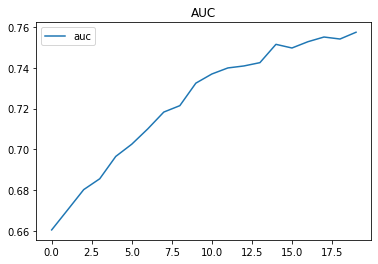

In [26]:
import matplotlib.pyplot as plt

# Loss curve
plt.plot(epoch_auc)
plt.title('AUC')
plt.legend(['auc'])
plt.savefig('auc.png')
plt.show()